In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
demo_path ='Data\df_final_demo.txt'
final_experiment_path = 'Data\df_final_experiment_clients.txt'
final_web_data_1_path = 'Data\df_final_web_data_pt_1.txt'
final_web_data_2_path = 'Data\df_final_web_data_pt_2.txt'

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Santi\AppData\Local\Temp\ipykernel_4128\4223594997.py:1: SyntaxWarning: invalid escape sequence '\d'
  demo_path ='Data\df_final_demo.txt'
C:\Users\Santi\AppData\Local\Temp\ipykernel_4128\4223594997.py:2: SyntaxWarning: invalid escape sequence '\d'
  final_experiment_path = 'Data\df_final_experiment_clients.txt'
C:\Users\Santi\AppData\Local\Temp\ipykernel_4128\4223594997.py:3: SyntaxWarning: invalid escape sequence '\d'
  final_web_data_1_path = 'Data\df_final_web_data_pt_1.txt'
C:\Users\Santi\AppData\Local\Temp\ipykernel_4128\4223594997.py:4: SyntaxWarning: invalid escape sequence '\

In [4]:
demo_df = pd.read_csv(demo_path)

In [5]:
final_ex_clients_df = pd.read_csv(final_experiment_path)

In [6]:
final_web_1 = pd.read_csv(final_web_data_1_path)

In [7]:
final_web_2 = pd.read_csv(final_web_data_2_path)
final_web_df = pd.concat([final_web_1, final_web_2])


In [8]:
def get_distribution_meassure_numerical(dataframe, column_name):
    """
    Returns mean, median, mode, var, std, range and quantiles for the given column of dataframe
    Also shows a historigram

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the numerical column to analyze.

    Returns (not implemented):
        mean (int).
        median (int).
        mode (int).
        variation (int).
        standard deviation (int).
        range (int): calculated by the following formula dataframe[column_name].max() - dataframe[column_name].min()
        quantiles (pd.Dataframe).

    """
    mean = dataframe[column_name].mean()
    median = dataframe[column_name].median()
    mode = dataframe[column_name].mode()[0]
    var = dataframe[column_name].var()
    std = dataframe[column_name].std()

    d_min = dataframe[column_name].min()
    d_max = dataframe[column_name].max()
    d_range = d_max - d_min

    quantiles = dataframe[column_name].quantile([0.25, 0.50, 0.75])

    print('------------------------')
    print(f'distribution meassures for {column_name}')
    print('------------------------')
    print(f""""
    mean is {mean}
    median is {median}
    mode is {mode}
    var is {var}
    std is {std}
    max is {d_max} and min is {d_min}
    range is {d_range}
    quantiles are {quantiles}
    """)

    sns.histplot(dataframe[column_name], kde=True, color='salmon')
    plt.show()


In [9]:
def get_bar_plot(column_x, column_y):
    """
    returns bar plot
    """
    sns.barplot(x = column_x,
            y = column_y,
            palette='Set2',
            hue = column_x)

    plt.xticks(rotation=70, fontsize=9)
    plt.show()

In [10]:
def get_frequencies(dataframe, column_name):
    """
    Returns frequency and proportion tables for the given column of dataframe
    Also displays a bar plot for the frequency table.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to analyze.

    Returns (not implemented):
        frequency_table (pd.Series): Count of each category.
        proportion_table (pd.Series): Proportion of each category.
    """
    frequency_table = dataframe[column_name].value_counts()

    proportion_table = dataframe[column_name].value_counts(normalize=True).apply(lambda x: f"{x:.2%}")

    print(frequency_table)
    print (proportion_table)
    get_bar_plot(column_x= frequency_table.index, column_y=frequency_table.values)

In [11]:
def get_frequencies_null_values(dataframe, column_name):
    """
    Returns frequency and proportion tables for the given column of dataframe
    Also displays a bar plot for the frequency table.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to analyze.

    Returns (not implemented):
        frequency_table (pd.Series): Count of each category.
        proportion_table (pd.Series): Proportion of each category.
    """
    frequency_table = dataframe[column_name].value_counts(dropna=False)

    proportion_table = dataframe[column_name].value_counts(dropna=False, normalize=True).apply(lambda x: f"{x:.2%}")

    print(frequency_table)
    print (proportion_table)
    get_bar_plot(column_x= frequency_table.index.astype(str), column_y=frequency_table.values)

In [12]:
"""
1. Observe which columns are numerical and which are categorical:
2. Are there any columns that are numerical but can be considered categorical?
3. Which are continuous and which are ordinal observations
4. Proceed with the analysis
"""

numerical_df = demo_df.select_dtypes('number')
categorical_df = demo_df.select_dtypes('object')

#Drop client id as it is not relevant for analysis
numerical_df.drop('client_id', axis=1, inplace=True)

In [13]:
def get_generation():
    """
    This function merges the demographic dataframe with the web dataframe to calculate the generation of each client:
    Extracts year from date_time (from web dataframe)
    Calculates year_born (year - age) -> rounded to 0 decimals
    Calculates generation by binning year_born up until 2018 (data ends in 2017)
    """
    merged_df = pd.merge(left=demo_df, right=final_web_df, how='inner', on='client_id')
    merged_df['date_time'] = pd.to_datetime(merged_df['date_time'])
    merged_df['year'] = merged_df['date_time'].dt.year
        
    gen_df = merged_df[['client_id', 'clnt_age', 'gendr', 'year']]
    gen_df = gen_df.groupby(['client_id', 'gendr']).agg(age = ('clnt_age', 'mean'), year = ('year', 'mean')).reset_index()
    gen_df['year_born'] = round(gen_df['year'] - gen_df['age'], 0)
    bins = [1925, 1945, 1964, 1980, 1996, 2018]
    labels = ['silent generation', 'baby boomers', 'generation x', 'millenial', 'generation z']
    gen_df['generation'] = pd.cut(gen_df['year_born'], bins = bins, labels = labels)
    gen_df = gen_df[['client_id', 'gendr', 'generation']]
    return gen_df

clnt_gen_df = get_generation()

gendr
M    23724
F    22746
Name: count, dtype: int64
gendr
M    51.05%
F    48.95%
Name: proportion, dtype: object


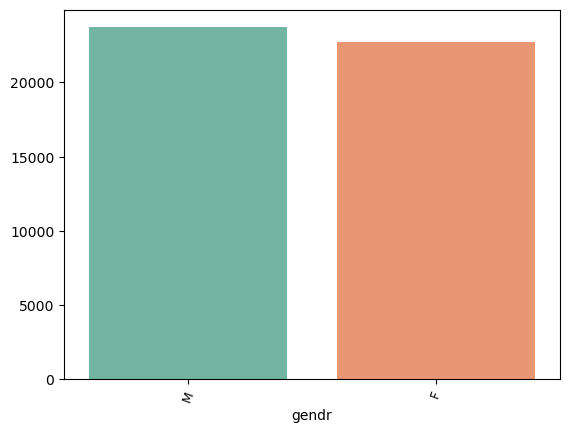

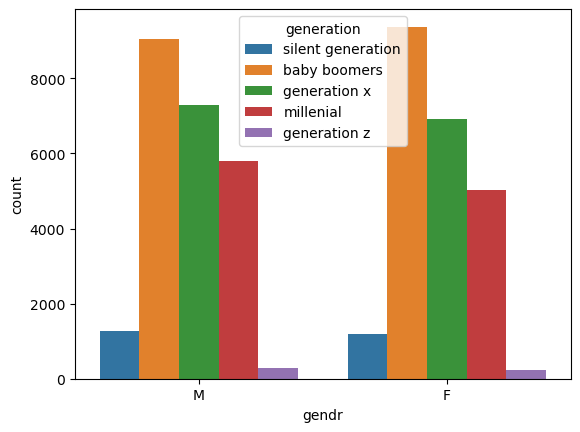

In [14]:
#There are too many unknown/undefined we will study male and female only
m_mask = categorical_df['gendr'] == 'M'
f_mask = categorical_df['gendr'] == 'F'

masked_categorical_df = categorical_df[m_mask | f_mask]
get_frequencies(masked_categorical_df, 'gendr')

m_mask = clnt_gen_df['gendr'] == 'M'
f_mask = clnt_gen_df['gendr'] == 'F'

masked_clnt_gen_df = clnt_gen_df[m_mask | f_mask]
sns.countplot(data=masked_clnt_gen_df, x='gendr', hue='generation')
plt.show()

------------------------
distribution meassures for clnt_tenure_yr
------------------------
"
    mean is 12.052949925632127
    median is 11.0
    mode is 6.0
    var is 47.22188958238263
    std is 6.871818506216723
    max is 62.0 and min is 2.0
    range is 60.0
    quantiles are 0.25     6.0
0.50    11.0
0.75    16.0
Name: clnt_tenure_yr, dtype: float64
    


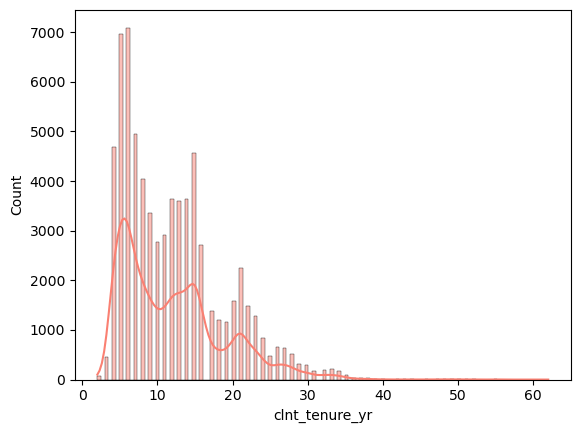

------------------------
distribution meassures for clnt_tenure_mnth
------------------------
"
    mean is 150.65936681068064
    median is 136.0
    mode is 58.0
    var is 6738.744167970153
    std is 82.08985423284751
    max is 749.0 and min is 33.0
    range is 716.0
    quantiles are 0.25     82.0
0.50    136.0
0.75    192.0
Name: clnt_tenure_mnth, dtype: float64
    


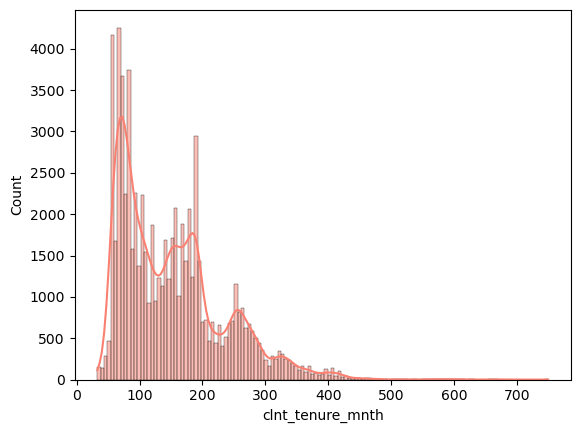

------------------------
distribution meassures for clnt_age
------------------------
"
    mean is 46.442240133722414
    median is 47.0
    mode is 58.5
    var is 243.08778114182405
    std is 15.59127259532794
    max is 96.0 and min is 13.5
    range is 82.5
    quantiles are 0.25    32.5
0.50    47.0
0.75    59.0
Name: clnt_age, dtype: float64
    


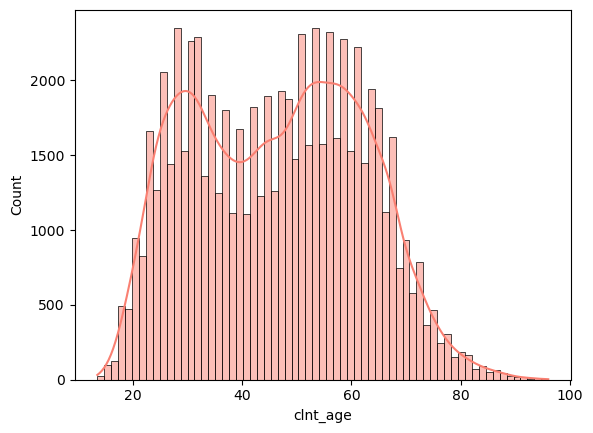

------------------------
distribution meassures for num_accts
------------------------
"
    mean is 2.2555280118988597
    median is 2.0
    mode is 2.0
    var is 0.2862216363058199
    std is 0.5349968563513434
    max is 8.0 and min is 1.0
    range is 7.0
    quantiles are 0.25    2.0
0.50    2.0
0.75    2.0
Name: num_accts, dtype: float64
    


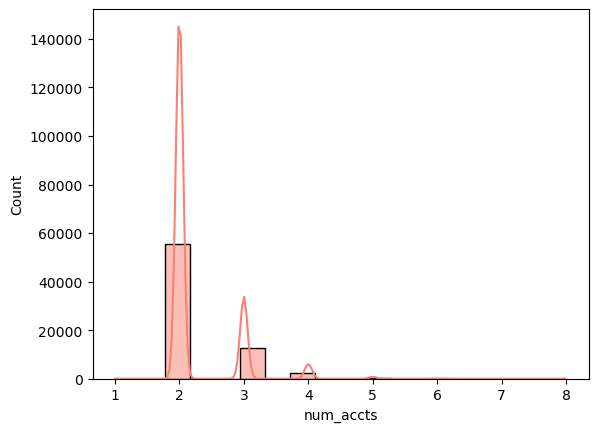

------------------------
distribution meassures for bal
------------------------
"
    mean is 147445.2406414052
    median is 63332.9
    mode is 31188.62
    var is 90907500113.93842
    std is 301508.70653090335
    max is 16320040.15 and min is 13789.419999999998
    range is 16306250.73
    quantiles are 0.25     37346.835
0.50     63332.900
0.75    137544.905
Name: bal, dtype: float64
    


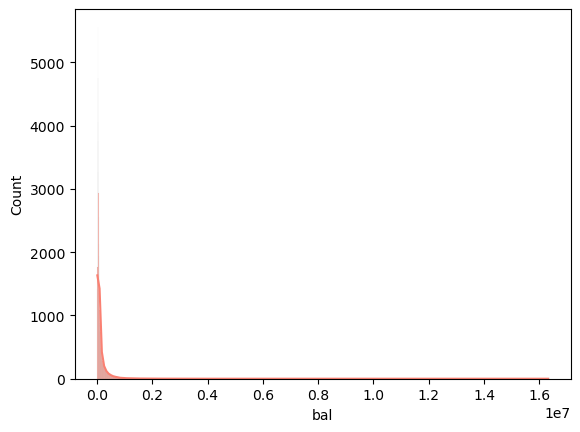

------------------------
distribution meassures for calls_6_mnth
------------------------
"
    mean is 3.382477512571712
    median is 3.0
    mode is 6.0
    var is 5.002290912585853
    std is 2.2365801824629163
    max is 7.0 and min is 0.0
    range is 7.0
    quantiles are 0.25    1.0
0.50    3.0
0.75    6.0
Name: calls_6_mnth, dtype: float64
    


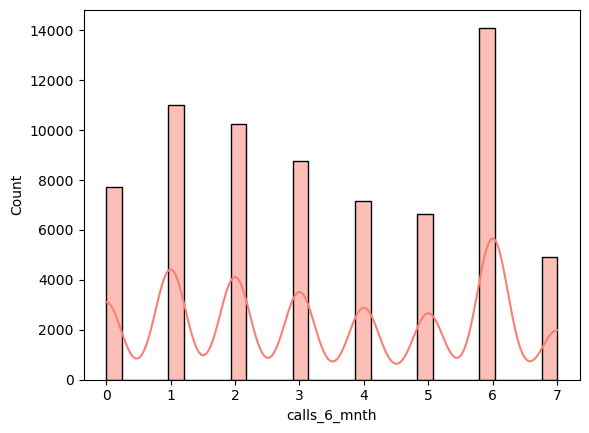

------------------------
distribution meassures for logons_6_mnth
------------------------
"
    mean is 5.566739854097316
    median is 5.0
    mode is 9.0
    var is 5.537953723792834
    std is 2.3532857293139804
    max is 9.0 and min is 1.0
    range is 8.0
    quantiles are 0.25    4.0
0.50    5.0
0.75    7.0
Name: logons_6_mnth, dtype: float64
    


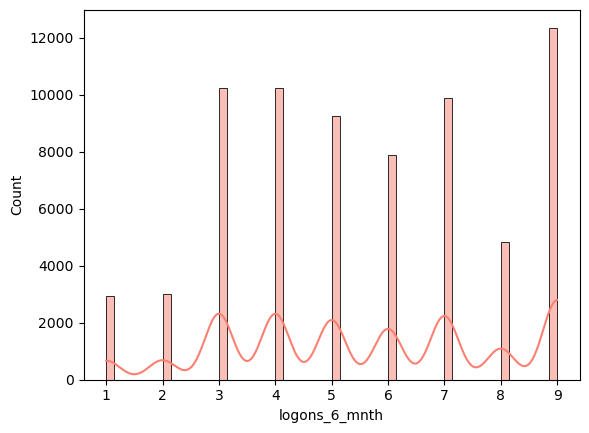

In [15]:
for column in numerical_df.columns:
    get_distribution_meassure_numerical(numerical_df, column)

Variation
Test       26968
Control    23532
NaN        20109
Name: count, dtype: int64
Variation
Test       38.19%
Control    33.33%
NaN        28.48%
Name: proportion, dtype: object


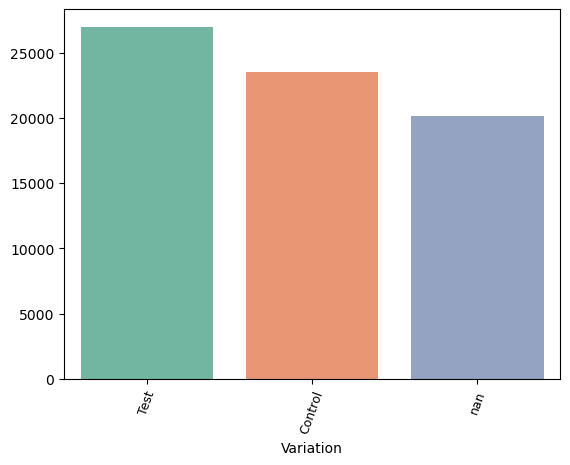

In [16]:
get_frequencies_null_values(final_ex_clients_df, 'Variation')
final_ex_clients_df['Variation'].value_counts(dropna=False)
final_ex_clients_df['Variation'].value_counts(dropna=False, normalize=True).apply(lambda x: f"{x:.2%}")
#removing null values from experiment file
final_ex_clients_df_clean = final_ex_clients_df.dropna()

In [17]:
def get_variation(dataframe):
    dataframe_clean = dataframe['client_id'].isin(final_ex_clients_df_clean['client_id'])
    #adding Variation column to web path file by merging with experiment file. This will enable us to calculate KPIs for both groups. 
    dataframe_clean = pd.merge(final_ex_clients_df_clean, dataframe, on='client_id')
    #defining test and control group
    return dataframe_clean

In [18]:
def get_group(dataframe): 
    test_group = dataframe[dataframe['Variation']=='Test']
    control_group = dataframe[dataframe['Variation']=='Control']

    return test_group, control_group

In [19]:
demo_df_clean = get_variation(demo_df)
clnt_gen_df_clean = get_variation(clnt_gen_df)
final_web_df_clean = get_variation(final_web_df)

In [20]:
def completion_rate(df):
    completed_df = df[df['process_step']=='confirm']

    completion_rate = completed_df['client_id'].nunique() / df['client_id'].nunique()

    return completion_rate

In [22]:
print(completion_rate(get_group(final_web_df_clean)[0]))
print(completion_rate(get_group(final_web_df_clean)[1]))

0.6929323642835954
0.6558728539860615


In [23]:
# Time Spent on Each Step
def time_spent_on_each_step(df):
    df = df.copy()
    df['next_date_time'] = df.groupby('visit_id')['date_time'].shift(1)
    df['duration'] = pd.to_datetime(df['next_date_time'])-pd.to_datetime(df['date_time'])
    time_spent_on_each_step = df['duration'].mean()
    return time_spent_on_each_step

In [24]:
print(time_spent_on_each_step(get_group(final_web_df_clean)[0]))
print(time_spent_on_each_step(get_group(final_web_df_clean)[1]))

0 days 00:01:10.492306926
0 days 00:01:10.959460066


In [25]:
def get_errors(step_dataframe):
    """
    This function returns if a step has an error (meaning the previous step is the same as the next)
    It makes sure that the client_id and visit_id are the same (no errors between different clients/sessions)
    
    Parameters:
    step_dataframe (pd.DataFrame): it is important that this df has client_id, visit_id and process_step for this function to work

    Returns:
    df['step_validation] (pd.Series)
    """

    step_to_int = {'start': 0,
                   'step_1': 1,
                   'step_2': 2,
                   'step_3' : 3,
                   'confirm': 4}
    step_dataframe = step_dataframe.copy()
    step_dataframe = step_dataframe.sort_values(by='date_time', ascending=True)
    function_df = step_dataframe[['client_id', 'visit_id', 'process_step']]
    function_df['step_int'] = function_df['process_step'].map(step_to_int)
    function_df['next_expected_step'] = function_df['step_int']+1
    function_df = function_df.reset_index(drop=True)

    condition_client = function_df['client_id'] == function_df['client_id'].shift(-1)
    condition_visit = function_df['visit_id'] == function_df['visit_id'].shift(-1)
    condition_expected_step = function_df['next_expected_step'] != function_df['step_int'].shift(-1)

    function_df['step_validation'] = np.where(condition_client & condition_visit & condition_expected_step, 
                                    'error', 
                                    'ok')

    return function_df['step_validation']


In [26]:
final_web_df['step_validation'] = get_errors(final_web_df_clean)
error_ratio = final_web_df['step_validation'].value_counts()[1]/len(final_web_df['step_validation'])

C:\Users\Santi\AppData\Local\Temp\ipykernel_4128\2033972930.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  function_df['step_int'] = function_df['process_step'].map(step_to_int)
C:\Users\Santi\AppData\Local\Temp\ipykernel_4128\2033972930.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  function_df['next_expected_step'] = function_df['step_int']+1
C:\Users\Santi\AppData\Local\Temp\ipykernel_4128\4264657497.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future

In [27]:
print( f'error ratio is {round(error_ratio*100,2)}%')

error ratio is 5.08%
